In [1]:
import sys
sys.path.append("..")
from utils import read_patients_metadata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_lesions, apply_cleaner, load_patient_lesions, get_folds_structure
from config import *
import numpy as np
import pandas as pd

Loading configuration...
Configuration loaded successfully!
_____________________________



In [2]:
ONLY_CLEANED = True
FOLDS_VERSION = "all"

In [ ]:
#apply_cleaner(lpp, PATCH_SIZE)
data = read_patients_metadata(PATCH_SIZE)

In [4]:
print(data[DATASET_BASEL_ID][121].keys())

dict_keys(['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015'])


In [ ]:
def show_count(ax):
    max_heigh = max([p.get_height() for p in ax.patches])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 0.03 * max_heigh,
                '{:d}'.format(int(height)),
                ha="center") 

In [ ]:

    
def get_dataframe_from_metadata(only_cleaned=True):
    # We process the data
    folds = get_folds_structure(version=FOLDS_VERSION)
    data_list = []
    for i in range(len(folds)):
        pd_data = [("Basel" if db == 0 else "CHUV", pat, les, "Rim+" if int(les) // 1000 == 1 else "Rim-", 
                    i, int(data[db][int(pat)][les]["volume"]), 
                    data[db][int(pat)][les]["ignore"],
                    np.NaN if len(data[db][int(pat)][les]["reasons_to_ignore"]) == 0 else get_exclusion_reason(int(min(data[db][int(pat)][les]["reasons_to_ignore"]))),
                    data[db][int(pat)][les]["reasons_to_ignore"])
                   for (db, pat) in folds[i]
                   for les in data[db][int(pat)]
                   if (not only_cleaned) or (not data[db][int(pat)][les]["ignore"])]
        data_list.append(pd.DataFrame(data = pd_data, columns=["Dataset", "Patient", "Lesion", "Type", "Fold", "Volume", "Ignore", "Main_reason", "Reasons"]))
    df = pd.concat(data_list)
    return df


In [10]:
df = get_dataframe_from_metadata(only_cleaned=ONLY_CLEANED)

In [9]:
df = df.reset_index()
df = df.drop(df[df["Dataset"] == "CHUV"].index)

## 1. Dataset analysis

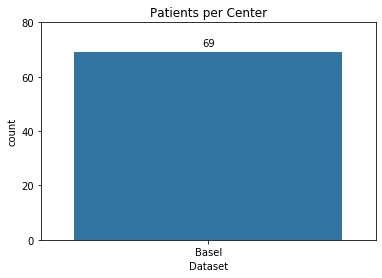

In [52]:
show_count(sns.countplot(data=df.groupby("Patient").first(), x="Dataset"))
plt.yticks(range(0, 100, 20))
plt.title("Patients per Center")
plt.show()

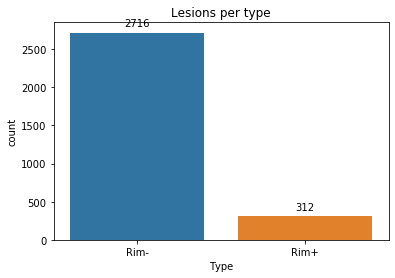

In [53]:
show_count(sns.countplot(data=df, x="Type"))
#plt.yticks(range(0, 6001, 1000))
plt.title("Lesions per type")
plt.show()

In [10]:
print("Range of volumes")
print(np.min(df["Volume"]))
print(np.max(df["Volume"]))

Range of volumes
45
9947


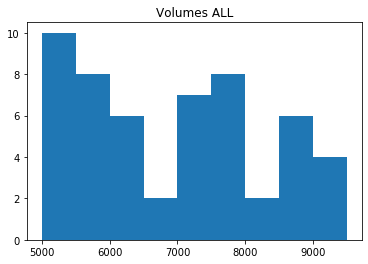

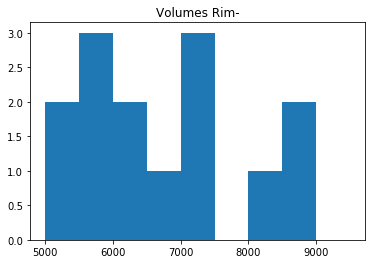

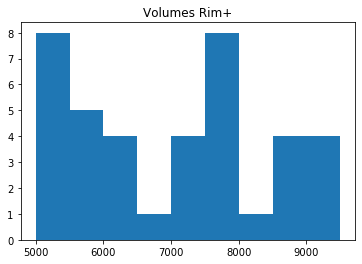

In [11]:
bins = range(5000, 10000, 500)

plt.hist(df["Volume"], bins=bins)
plt.title("Volumes ALL")
plt.show()

plt.hist(df.loc[df["Type"] == "Rim+", "Volume"], bins=bins)
plt.title("Volumes Rim-")
plt.show()

plt.hist(df.loc[df["Type"] == "Rim-", "Volume"], bins=bins)
plt.title("Volumes Rim+")
plt.show()

## 2. Folds analysis

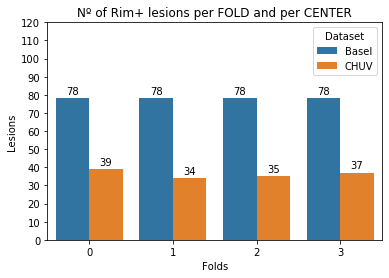

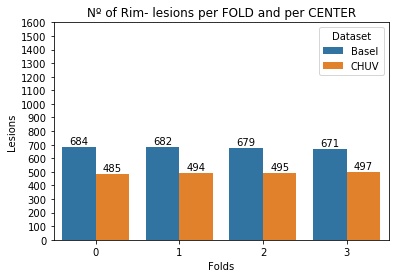

In [12]:
import pandas as pd

def show_num_lesions_per_fold(rim = True):
    
    if rim:
        ax = sns.countplot(x="Fold", hue="Dataset", data=df.loc[df["Type"] == "Rim+"].sort_values("Dataset"))
        plt.yticks(range(0, 121, 10))
    else:
        ax = sns.countplot(x="Fold", hue="Dataset", data=df.loc[df["Type"] == "Rim-"].sort_values("Dataset"))
        plt.yticks(range(0, 1601, 100))
        
    show_count(ax)
    plt.xlabel("Folds")
    plt.ylabel("Lesions")
    plt.title(f"Nº of Rim{'+' if rim else '-'} lesions per FOLD and per CENTER")
    plt.savefig(f'./figs/per_fold_rim_{rim}.png', dpi = 250, format="png", bbox_inches='tight')
    plt.show()
    
show_num_lesions_per_fold(rim=True)
show_num_lesions_per_fold(rim=False)

In [13]:
arr = (684,682,679,671)
print(np.mean(arr))
print(np.std(arr))

arr = (485,494,495,497)
print(np.mean(arr))
print(np.std(arr))

679.0
4.949747468305833
492.75
4.602988159880492


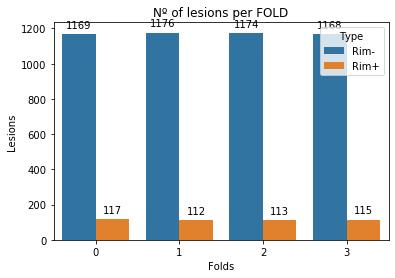

In [14]:
import pandas as pd

def show_proportions_per_fold():
    ax = sns.countplot(x="Fold", hue="Type", data=df)
    show_count(ax)
    
    #plt.yticks(range(0, 2100, 500))
    plt.xlabel("Folds")
    plt.ylabel("Lesions")
    plt.title("Nº of lesions per FOLD")
    plt.savefig(f'./figs/comparison_PT_rims_proportion.png', dpi = 250, format="png", bbox_inches='tight')
    plt.show()
    
show_proportions_per_fold()

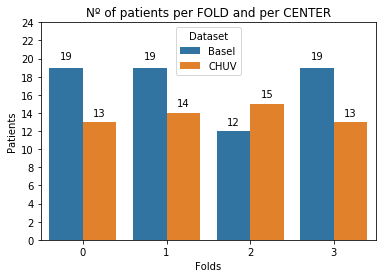

In [15]:
import pandas as pd

ax = sns.countplot(x="Fold", hue="Dataset", data=df.groupby("Patient").first().sort_values("Dataset"))
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.05 * height,
            '{:d}'.format(int(height)),
            ha="center") 
        
plt.yticks(range(0, 26, 2))
plt.xlabel("Folds")
plt.ylabel("Patients")
plt.title("Nº of patients per FOLD and per CENTER")
plt.savefig(f'./figs/per_fold_patients.png', dpi = 250, format="png", bbox_inches='tight')
plt.show()

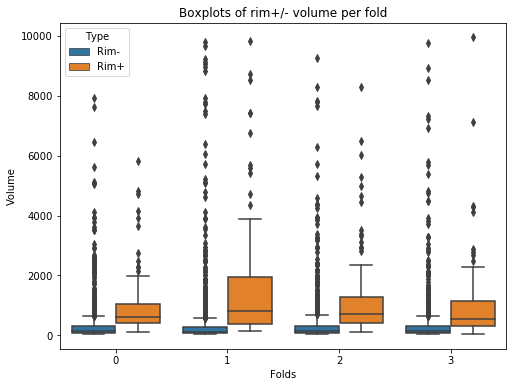

In [16]:
import pandas as pd

def show_volume_violin_plots(rim = True):
    plt.figure(figsize=(8,6))
    ax = sns.boxplot(x="Fold", y="Volume", hue="Type", data=df)
    
    #plt.ylim(0, 10500)
    #plt.yticks(range(0, 10500, 1000))
    plt.xlabel("Folds")
    plt.ylabel("Volume")
    plt.title("Boxplots of rim+/- volume per fold")
    plt.savefig(f'./figs/volume_boxplots_folds.png', dpi = 250, format="png", bbox_inches='tight')
    plt.show()
    
show_volume_violin_plots(rim=True)


0.5864332603938731
649.0
1186.0853391684902
819.5


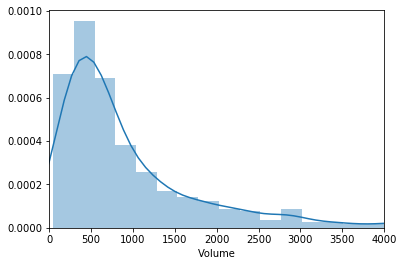

In [17]:
all_rim = df.loc[(df["Lesion"].astype(int) // 1000 == 1), "Volume"]
sns.distplot(all_rim)
plt.xlim((0, 4000))
print(len(all_rim.loc[all_rim < 800].index) / len(all_rim.index))
print(all_rim.median())
print(all_rim.mean())
print(np.percentile(all_rim, 60, interpolation = 'midpoint') )

## 3. Reasons to ignore

['< 45' 'Air artifact' '> 10000' 'Rim intrusion' 'Others']
1671
4451 (4138/313)
5144 (4687/457)


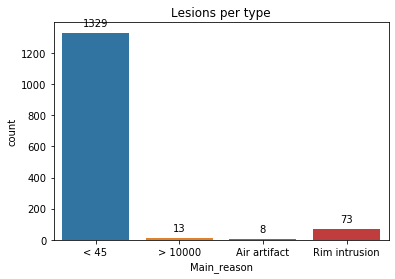

In [15]:
df_all = get_dataframe_from_metadata(only_cleaned=False)
print(df_all.loc[df_all["Ignore"] != 0, "Main_reason"].unique())
print(len(df_all[df_all["Main_reason"] == "< 45"]))
df_all = df_all.reset_index()
df_all = df_all.drop(df_all[df_all["Dataset"] == "CHUV"].index)

print(f'{len(df_all)} ({len(df_all[df_all["Type"] == "Rim-"])}/{len(df_all[df_all["Type"] == "Rim+"])})')
print(f'{len(df)} ({len(df[df["Type"] == "Rim-"])}/{len(df[df["Type"] == "Rim+"])})')

show_count(sns.countplot(data=df_all.loc[(df_all["Ignore"])].sort_values("Main_reason"), x="Main_reason"))
#plt.yticks(range(0, 2001, 500))
plt.title("Lesions per type")
plt.show()
#plt.savefig(f'./figs/cleaned.png', dpi = 250, format="png", bbox_inches='tight')

In [93]:
df_all[(df_all["Volume"] < 45) & (df_all["Dataset"] == "Basel")]

,Dataset,Patient,Lesion,Type,Fold,Volume,Ignore,Main_reason,Reasons
637,Basel,063,2021,Rim-,0,4,True,Others,[-1]
638,Basel,063,2022,Rim-,0,4,True,Others,[-1]
642,Basel,063,2026,Rim-,0,2,True,Others,[-1]
752,Basel,064,2097,Rim-,0,44,True,Others,[-1]
757,Basel,064,2102,Rim-,0,6,True,Others,[-1]
...,...,...,...,...,...,...,...,...,...
1754,Basel,128,2182,Rim-,3,43,True,Others,[-1]
1756,Basel,128,2184,Rim-,3,42,True,Others,[-1]
1757,Basel,128,2185,Rim-,3,32,True,Others,[-1]
1760,Basel,128,2188,Rim-,3,32,True,Others,[-1]


In [55]:
second_rating = pd.read_csv("/Users/german/Desktop/second_rating/second_rating.csv", sep=";")


correspondences = pd.read_csv("/Users/german/Desktop/RimProject/excels/all_participants.csv", sep=";")
correspondences["Patient"] = correspondences["participant_id"].apply(lambda idd: idd.split("-")[1])
correspondences["Hospital_ID"] = correspondences["center_id"]
correspondences = correspondences[["Patient", "Hospital_ID"]]
second_rating = pd.merge(second_rating, correspondences, on="Hospital_ID", how="left")
second_rating["Lesion"] = second_rating["Lesion_ID"].astype(str)
second_rating = second_rating[["Patient", "Lesion", "Result", "Hospital_ID"]]
second_rating

,Patient,Lesion,Result,Hospital_ID
0,013,2022,FP,33
1,014,1000,FN,34
2,029,1000,FN,73
3,029,1007,FN,73
4,039,1004,FN,104
...,...,...,...,...
78,129,2023,FP,INSIDER_P084
79,130,1001,FN,INSIDER_P085
80,130,1009,FN,INSIDER_P085
81,132,1001,FN,INSIDER_P091


In [57]:
found = pd.merge(second_rating, df_all[df_all["Ignore"] == True], on=["Patient", "Lesion"], how="left")
found.loc[found["Ignore"] == True]
#found.to_csv("/Users/german/Desktop/second_rating/special_cases.csv")